The **Bio.Graphics.BasicChromosome** module in Biopython facilitates the creation of chromosome 
drawings. It relies on the ReportLab library for generating PDF, EPS, SVG, and bitmap images.
The module offers classes to represent and customize chromosome structures, segments, 
and annotations. The core classes include:

   **Organism**: Manages and draws multiple chromosomes within an organism.
   **Chromosome**: Represents a single chromosome, organizing its segments.
   **ChromosomeSegment**: Defines and draws a segment of a chromosome with customizable features.
   **AnnotatedChromosomeSegment**: Extends ChromosomeSegment to include annotations.
   **TelomereSegment**: Represents a telomere segment.
   **SpacerSegment**: Represents a spacer segment. 

**To use the module, one typically instantiates an Organism, adds Chromosome objects to it, 
and then adds ChromosomeSegment objects to the chromosomes.** 
Customization options are available for segment colors, positions, and annotations. 
The draw method of the Organism class then generates the final chromosome drawing.

In [1]:
from collections import defaultdict
import gffutils
import sqlite3
import pygraphviz as pgv
import requests
import gzip
from Bio import Seq, SeqIO, SeqUtils
from IPython.core.display import Image
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import BasicChromosome
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import IFrame

/home/veysel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
# !wget http://plasmodb.org/common/downloads/release-13.0/Pfalciparum3D7/fasta/data/PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta


--2025-02-02 20:15:53--  http://plasmodb.org/common/downloads/release-13.0/Pfalciparum3D7/fasta/data/PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta
128.192.21.13smodb.org (plasmodb.org)... 
connected. to plasmodb.org (plasmodb.org)|128.192.21.13|:80... 
301 Moved Permanentlyaiting response... 
Location: https://plasmodb.org/common/downloads/release-13.0/Pfalciparum3D7/fasta/data/PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta [following]
--2025-02-02 20:15:54--  https://plasmodb.org/common/downloads/release-13.0/Pfalciparum3D7/fasta/data/PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta
Connecting to plasmodb.org (plasmodb.org)|128.192.21.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23723399 (23M) [application/x-fasta]
Saving to: ‘PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta’

PlasmoDB-13.0_Pfalc 100%[===================>]  22.62M  26.0MB/s    in 0.9s    

2025-02-02 20:15:55 (26.0 MB/s) - ‘PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta’ saved [23723399/23723399]



In [6]:
genome_name = 'PlasmoDB-13.0_Pfalciparum3D7_Genome.fasta'

recs = SeqIO.parse(genome_name, 'fasta')
for rec in recs:
    print(rec.description)

Pf3D7_04_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1200490 | SO=chromosome
Pf3D7_05_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1343557 | SO=chromosome
Pf3D7_02_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=947102 | SO=chromosome
Pf3D7_09_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1541735 | SO=chromosome
Pf3D7_12_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=2271494 | SO=chromosome
Pf3D7_06_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1418242 | SO=chromosome
Pf3D7_14_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=3291936 | SO=chromosome
Pf3D7_03_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1067971 | SO=chromosome
Pf3D7_07_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | length=1445207 | SO=chromosome
Pf3D7_13_v3 | organism=Plasmodium_falciparum_3D7 | version=2013-03-01 | le

In [9]:
recs = SeqIO.parse(genome_name, 'fasta')
for rec in recs:
    print(rec.description.find('SO=chromosome'))

89
89
88
89
89
89
89
89
89
89
89
88
89
89
-1
-1


In [11]:
chroms = {}
chrom_sizes = {}
chrom_GC = {}
recs = SeqIO.parse(genome_name, 'fasta')
block_size = 50000 #The size of the window (50,000 bases) used to partition each chromosome. The genome will be divided into blocks of 50,000 bases.
min_GC = 100.0
max_GC = 0.0
for rec in recs:
    if rec.description.find('SO=chromosome') == -1: # we ignore the mitochondrion and apicoplast
        continue
    chrom = int(rec.description.split('_')[1]) # Take the chrm number (second element)
    chrom_GC[chrom] = []
    size = len(rec.seq)
    chrom_sizes[chrom] = size
    num_blocks = size // block_size + 1 # Adding 1 ensures that any remaining bases
    for block in range(num_blocks):
        start = block_size * block
        if block == num_blocks - 1:
            end = size
        else:
            end = block_size + start + 1 #  This adds one extra base to each block except the last one, creating a slight overlap.
        block_seq = rec.seq[start:end]
        block_GC = SeqUtils.gc_fraction(block_seq)*100
        if block_GC < min_GC:
            min_GC = block_GC
        if block_GC > max_GC:
            max_GC = block_GC
        chrom_GC[chrom].append(block_GC)
print(min_GC, max_GC)

16.141677166456674 43.673469387755105


In [22]:
chroms = list(chrom_sizes.keys())
chroms.sort()

biggest_chrom = max(chrom_sizes.values())

my_genome = BasicChromosome.Organism(output_format="pdf")

my_genome.page_size = (29.7*cm, 21*cm) # check
telomere_length = 10

bottom_GC = 17.5
top_GC = 22.0
for chrom in chroms:
    chrom_size = chrom_sizes[chrom]
    chrom_representation = BasicChromosome.Chromosome('Cr %d' % chrom)
    chrom_representation.scale_num = biggest_chrom

    tel = BasicChromosome.TelomereSegment()
    tel.scale = telomere_length
    chrom_representation.add(tel)

    num_blocks = len(chrom_GC[chrom])
    for block, gc in enumerate(chrom_GC[chrom]):
        my_GC = chrom_GC[chrom][block]
        body = BasicChromosome.ChromosomeSegment()
        if my_GC > top_GC:
            body.fill_color = colors.Color(1, 0, 0)
        elif my_GC < bottom_GC:
            body.fill_color = colors.Color(1, 1, 0)
        else:
            my_color = (my_GC - bottom_GC) / (top_GC - bottom_GC)
            body.fill_color = colors.Color(my_color, my_color, 1)
        if block < num_blocks - 1:
            body.scale = block_size
        else:
            body.scale = chrom_size % block_size
        chrom_representation.add(body)

    tel = BasicChromosome.TelomereSegment(inverted=True)
    tel.scale = telomere_length
    chrom_representation.add(tel)

    my_genome.add(chrom_representation)

my_genome.draw("falciparum.pdf", "Plasmodium falciparum")
#Image("falciparum.pdf")
IFrame("falciparum.pdf", width=800, height=600)

In [24]:
# !wget https://vectorbase.org/common/downloads/Current_Release/AgambiaePEST/fasta/data/VectorBase-67_AgambiaePEST_Genome.fasta -O gambiae.fa
# !gzip -9 gambiae.fa
# !wget https://vectorbase.org/common/downloads/Current_Release/AatroparvusEBRO/fasta/data/VectorBase-67_AatroparvusEBRO_Genome.fasta -O atroparvus.fa
# !gzip -9 atroparvus.fa

--2025-02-02 22:47:09--  https://vectorbase.org/common/downloads/Current_Release/AgambiaePEST/fasta/data/VectorBase-67_AgambiaePEST_Genome.fasta
Resolving vectorbase.org (vectorbase.org)... 128.192.21.13
connected. to vectorbase.org (vectorbase.org)|128.192.21.13|:443... 
HTTP request sent, awaiting response... 404 Not Found
2025-02-02 22:47:09 ERROR 404: Not Found.

gzip: gambiae.fa.gz already exists; do you wish to overwrite (y or n)? ^C
--2025-02-02 22:58:45--  https://vectorbase.org/common/downloads/Current_Release/AatroparvusEBRO/fasta/data/VectorBase-67_AatroparvusEBRO_Genome.fasta
128.192.21.13torbase.org (vectorbase.org)... 
connected. to vectorbase.org (vectorbase.org)|128.192.21.13|:443... 
HTTP request sent, awaiting response... 404 Not Found
2025-02-02 22:58:50 ERROR 404: Not Found.

gzip: atroparvus.fa.gz already exists; do you wish to overwrite (y or n)? ^C


In [25]:
gambiae_name = 'gambiae.fa'
atroparvus_name = 'atroparvus.fa'

recs = SeqIO.parse(gambiae_name, 'fasta')
for rec in recs:
    print(rec.description)

AgamP4_2L | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=49364325 | SO=chromosome
AgamP4_2R | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=61545105 | SO=chromosome
AgamP4_3L | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=41963435 | SO=chromosome
AgamP4_3R | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=53200684 | SO=chromosome
AgamP4_UNKN | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=42389979 | SO=chromosome
AgamP4_X | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=24393108 | SO=chromosome
AgamP4_Y_unplaced | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=237045 | SO=chromosome
AAAB01000047 | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=21505 | SO=supercontig
AAAB01000163 | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=28420 | SO=supercontig
AAAB01000448 | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=22809 | SO=supercontig
AAAB01000791 | organism=Anopheles_gambia

In [26]:
recs = SeqIO.parse(gambiae_name, 'fasta')
chrom_Ns = {}
chrom_sizes = {}
for rec in recs:
    if rec.description.find('supercontig') > -1:
        continue
    print(rec.description, rec.id, rec)
    chrom = rec.id.split('_')[1]
    if chrom in ['UNKN']:#, 'Y_unplaced']:
        continue
    chrom_Ns[chrom] = []
    on_N = False
    curr_size = 0
    for pos, nuc in enumerate(rec.seq):
        if nuc in ['N', 'n']:
            curr_size += 1
            on_N = True
        else:
            if on_N:
                chrom_Ns[chrom].append(curr_size)
                curr_size = 0
            on_N = False
    if on_N:
        chrom_Ns[chrom].append(curr_size)
    chrom_sizes[chrom] = len(rec.seq)

for chrom, Ns in chrom_Ns.items():
    size = chrom_sizes[chrom]
    if len(Ns) > 0:
        max_Ns = max(Ns)
    else:
        max_Ns = 'NA'
    print(f'{chrom} ({size}): %Ns ({round(100 * sum(Ns) / size, 1)}), num Ns: {len(Ns)}, max N: {max_Ns}')


AgamP4_2L | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=49364325 | SO=chromosome AgamP4_2L ID: AgamP4_2L
Name: AgamP4_2L
Description: AgamP4_2L | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=49364325 | SO=chromosome
Number of features: 0
Seq('AACCATGGTCCAGAGTACACATTGACTATGCAGGCCTAGTAGACGAATTCTACT...AAA')
AgamP4_2R | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=61545105 | SO=chromosome AgamP4_2R ID: AgamP4_2R
Name: AgamP4_2R
Description: AgamP4_2R | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=61545105 | SO=chromosome
Number of features: 0
Seq('CTCTAAACATTAATAAAACCAAATACATGATCATATCAAACAAAAATAATCAAG...ACA')
AgamP4_3L | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=41963435 | SO=chromosome AgamP4_3L ID: AgamP4_3L
Name: AgamP4_3L
Description: AgamP4_3L | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=41963435 | SO=chromosome
Number of features: 0
Seq('ACGAAAAGCCAATTGTAAAAAAACCATACACGCGTCGAAACACGACAAACCAAG...TCC')
A

In [27]:
recs = SeqIO.parse(atroparvus_name, 'fasta')
sizes = []
size_N = []
for rec in recs:
    size = len(rec.seq)
    sizes.append(size)
    count_N = 0
    for nuc in rec.seq:
        if nuc in ['n', 'N']:
            count_N += 1
    size_N.append((size, count_N / size))

print(len(sizes), 
      np.median(sizes), 
      np.mean(sizes), 
      max(sizes), 
      min(sizes), 
      np.percentile(sizes, 10), 
      np.percentile(sizes, 90))


1320 7811.5 170678.20075757575 58369459 1004 1537.1000000000001 39644.70000000007


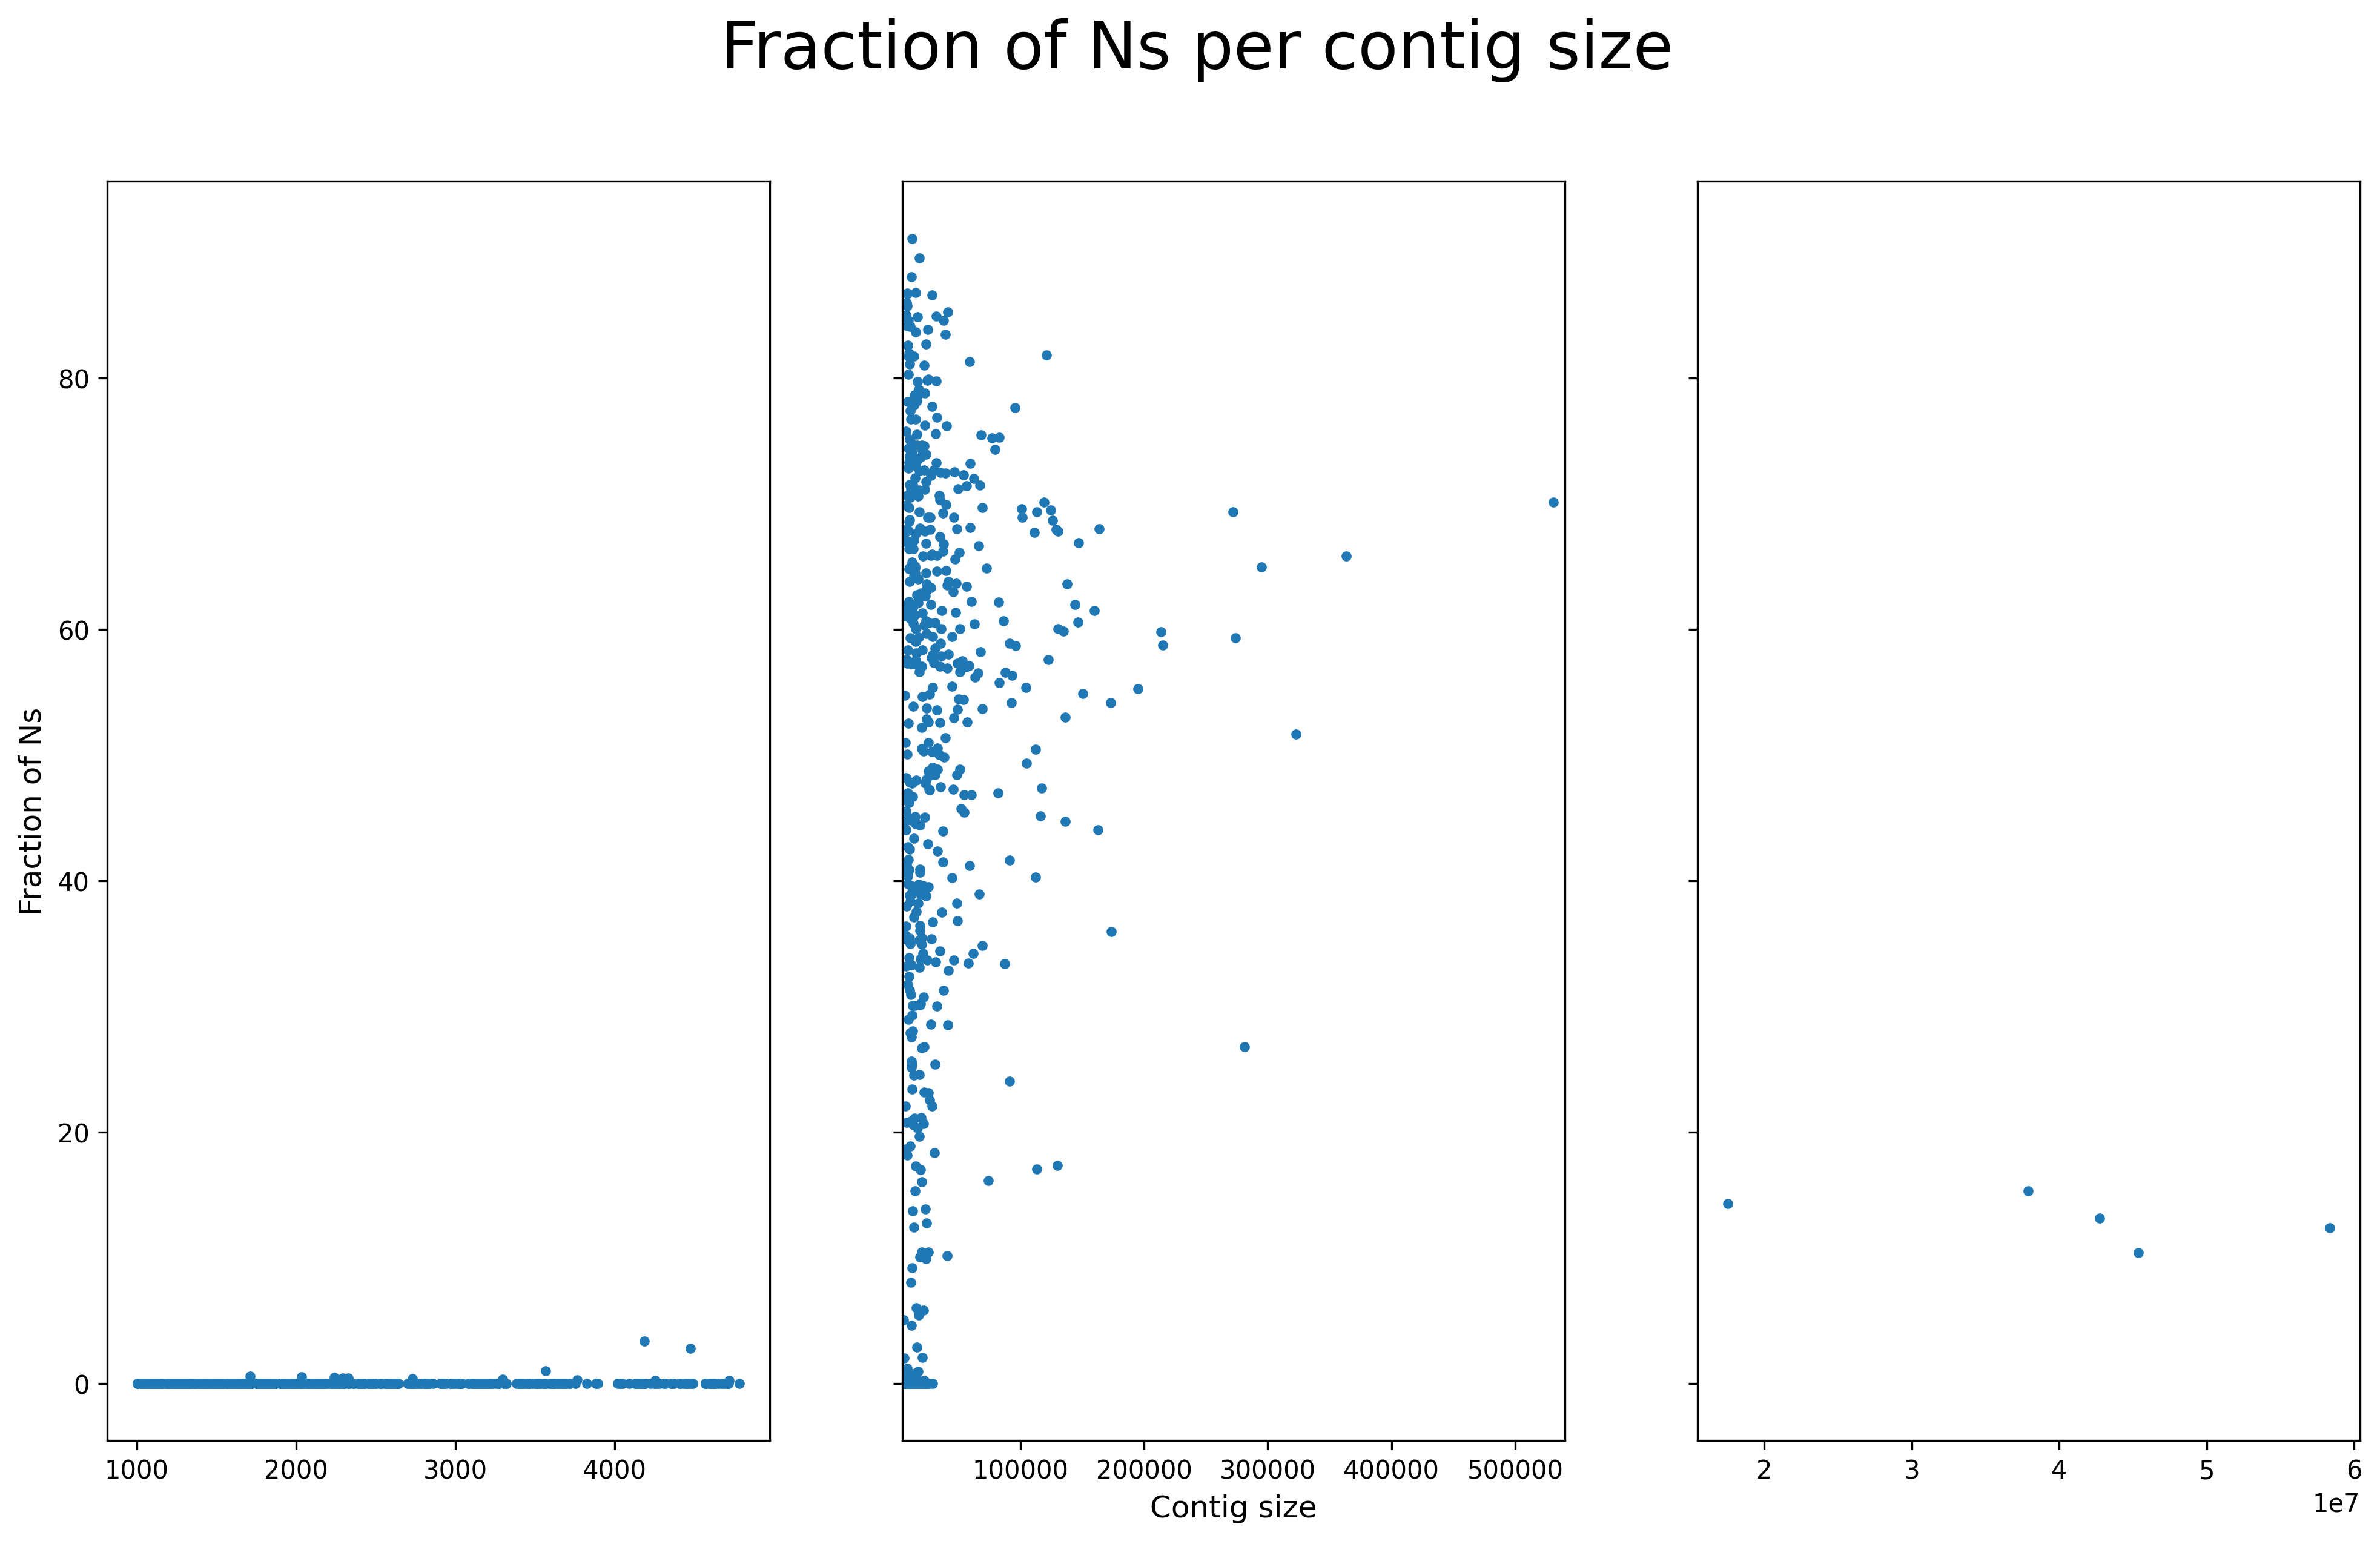

In [28]:
small_split = 4800
large_split = 540000
fig, axs = plt.subplots(1, 3, figsize=(16, 9), dpi=300, squeeze=False, sharey=True)
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x <= small_split])
axs[0, 0].plot(xs, ys, '.')
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x > small_split and x <= large_split])
axs[0, 1].plot(xs, ys, '.')
axs[0, 1].set_xlim(small_split, large_split)
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x > large_split])
axs[0, 2].plot(xs, ys, '.')
axs[0, 0].set_ylabel('Fraction of Ns', fontsize=12)
axs[0, 1].set_xlabel('Contig size', fontsize=12)
fig.suptitle('Fraction of Ns per contig size', fontsize=26)
fig.savefig('frac.png')

In [29]:
!wget https://vectorbase.org/common/downloads/release-55/AgambiaePEST/gff/data/VectorBase-55_AgambiaePEST.gff -O gambiae.gff


--2025-02-03 00:39:13--  https://vectorbase.org/common/downloads/release-55/AgambiaePEST/gff/data/VectorBase-55_AgambiaePEST.gff
128.192.21.13torbase.org (vectorbase.org)... 
connected. to vectorbase.org (vectorbase.org)|128.192.21.13|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 23512903 (22M) [application/x-gff]
Saving to: ‘gambiae.gff’

gambiae.gff         100%[===================>]  22.42M  21.7MB/s    in 1.0s    

2025-02-03 00:39:14 (21.7 MB/s) - ‘gambiae.gff’ saved [23512903/23512903]



In [30]:
!gzip -9 gambiae.gff

In [2]:
try:
    """
    gffutils.create_db('gambiae.gff.gz', 'ag.db'):

    This function reads the GFF file (here, 'gambiae.gff.gz') and creates a 
    SQLite-based database stored in the file 'ag.db'. The purpose is to parse the annotation 
    file and index all its features (such as genes, exons, etc.) so that you can perform fast 
    queries. Note: The input file is gzipped (ends with .gz), and gffutils can handle 
    compressed files.

Using a try/except Block:

    Try Block:
    The code attempts to create the database from the GFF file.
    Except Block:
    If a sqlite3.OperationalError is raised (for example, if the database 
    file 'ag.db' already exists or there is an operational problem with writing 
    to the database), the code instead loads the existing database using:
    """
    db = gffutils.create_db('gambiae.gff.gz', 'ag.db')
except sqlite3.OperationalError:
    db = gffutils.FeatureDB('ag.db')

print(list(db.featuretypes()))
for feat_type in db.featuretypes():
    print(feat_type, db.count_features_of_type(feat_type))

['CDS', 'RNase_MRP_RNA', 'RNase_P_RNA', 'SRP_RNA', 'exon', 'five_prime_UTR', 'lnc_RNA', 'mRNA', 'ncRNA', 'ncRNA_gene', 'pre_miRNA', 'protein_coding_gene', 'pseudogene', 'pseudogenic_transcript', 'rRNA', 'snRNA', 'snoRNA', 'tRNA', 'three_prime_UTR']
CDS 67394
RNase_MRP_RNA 1
RNase_P_RNA 1
SRP_RNA 3
exon 61590
five_prime_UTR 17472
lnc_RNA 2
mRNA 15125
ncRNA 4
ncRNA_gene 729
pre_miRNA 77
protein_coding_gene 13094
pseudogene 9
pseudogenic_transcript 9
rRNA 242
snRNA 35
snoRNA 2
tRNA 362
three_prime_UTR 12236


In [3]:
seqids = set()
for e in db.all_features():
    seqids.add(e.seqid)
for seqid in seqids:
    print(seqid)


AgamP4_Y_unplaced
AgamP4_UNKN
AgamP4_2L
AgamP4_Mt
AgamP4_3R
AgamP4_3L
AgamP4_X
AgamP4_2R


In [4]:
num_mRNAs = defaultdict(int)
num_exons = defaultdict(int)
max_exons = 0
max_span = 0
for seqid in seqids:
    cnt = 0
    #db.region(...) returns an iterator over all features (here, protein-coding genes) in that sequence region.
    for gene in db.region(seqid=seqid, featuretype='protein_coding_gene'):
        cnt += 1
        span = abs(gene.start - gene.end) # strand
        if span > max_span:
            max_span = span
            max_span_gene = gene
        """
        db.children(gene, featuretype='mRNA')
        This function returns the children features of the gene that have the type "mRNA".
        In many annotations, a gene may have multiple mRNA isoforms.
        num_mRNAs[len(my_mRNAs)] += 1
        Increments the count for the key corresponding to the number of mRNAs.
        For example, if a gene has 2 mRNAs, then len(my_mRNAs) equals 2 and 
        num_mRNAs[2] is incremented.
        """
        my_mRNAs = list(db.children(gene, featuretype='mRNA'))
        num_mRNAs[len(my_mRNAs)] += 1
        if len(my_mRNAs) == 0:
            """
            If the gene has no mRNA children (which is unusual but can happen), 
            the gene itself is used as the object to count exons.
            Otherwise, if there are mRNAs, then each mRNA is considered separately.
            The variable exon_check becomes a list of features (either one element: 
            the gene; or all mRNA isoforms).
            """
            exon_check = [gene]
        else:
            exon_check = my_mRNAs
        for check in exon_check:
            my_exons = list(db.children(check, featuretype='exon'))
            num_exons[len(my_exons)] += 1
            if len(my_exons) > max_exons:
                max_exons = len(my_exons)
                max_exons_gene = gene
    print(f'seqid {seqid}, number of genes {cnt}')
print('Max number of exons: %s (%d)' % (max_exons_gene.id, max_exons))
print('Max span: %s (%d)' % (max_span_gene.id, max_span))
print(num_mRNAs)
print(num_exons)

seqid AgamP4_Y_unplaced, number of genes 2
seqid AgamP4_UNKN, number of genes 478
seqid AgamP4_2L, number of genes 2950
seqid AgamP4_Mt, number of genes 13
seqid AgamP4_3R, number of genes 2692
seqid AgamP4_3L, number of genes 2216
seqid AgamP4_X, number of genes 1073
seqid AgamP4_2R, number of genes 3670
Max number of exons: AGAP001660 (69)
Max span: AGAP006656 (365621)
defaultdict(<class 'int'>, {1: 11753, 2: 964, 3: 234, 5: 27, 6: 10, 4: 85, 7: 5, 11: 3, 13: 2, 12: 2, 9: 3, 8: 4, 20: 1, 10: 1})
defaultdict(<class 'int'>, {3: 2763, 5: 1552, 1: 1207, 4: 2059, 2: 3159, 7: 786, 8: 530, 6: 1126, 11: 282, 15: 65, 12: 194, 9: 459, 10: 340, 13: 119, 14: 96, 18: 46, 19: 32, 28: 6, 17: 76, 16: 65, 20: 36, 24: 9, 33: 3, 21: 27, 22: 10, 31: 10, 32: 7, 25: 15, 23: 15, 30: 5, 29: 6, 26: 8, 27: 6, 37: 1, 35: 1, 45: 1, 38: 1, 46: 1, 69: 1})


In [5]:
# Getting a gene

gene_id = 'AGAP004707'
gene = db[gene_id]

print(gene)
print(gene.seqid, gene.strand)

recs = SeqIO.parse('gambiae.fa', 'fasta')
for rec in recs:
    print(rec.description)
    if rec.id == gene.seqid:
        my_seq = rec.seq
        break

AgamP4_2L	VEuPathDB	protein_coding_gene	2358158	2431617	.	+	.	ID=AGAP004707;Name=para;description=voltage-gated sodium channel
AgamP4_2L +
AgamP4_2L | organism=Anopheles_gambiae_PEST | version=AgamP4 | length=49364325 | SO=chromosome


In [6]:
def get_sequence(chrom_seq, CDSs, strand):
    """
    This function “stitches” together all CDS segments to form the complete coding sequence 
    for a transcript, correctly handling the strand.
    chrom_seq:
    The full chromosome sequence from which you will extract portions.
    CDSs:
    A iterator of CDS features (each with start and end coordinates).
    strand:
    The strand on which the gene is located (‘+’ or ‘-’).
    """
    seq = Seq.Seq('')
    for CDS in CDSs:
        # #FRAME???
        my_cds = Seq.Seq(str(chrom_seq[CDS.start - 1: CDS.end])) # FASTA (and GFF) coordinates are 1-based
        seq += my_cds
    return seq if strand == '+' else seq.reverse_complement()

In [7]:
mRNAs = db.children(gene, featuretype='mRNA')
for mRNA in mRNAs:
    print(mRNA.id)
    """
    The loop prints the ID of each mRNA. It breaks when it finds one whose ID ends with 'RA' 
    (commonly used in some annotation systems to denote the “reference” transcript among 
    multiple isoforms).
    """
    if mRNA.id.endswith('RA'):
        break
# Retrieves all CDS features that are children of the mRNA, ordered by their start coordinate.
CDSs = db.children(mRNA, featuretype='CDS', order_by='start')
gene_seq = get_sequence(my_seq, CDSs, gene.strand)

print(len(gene_seq), gene_seq)
prot = gene_seq.translate()
print(len(prot), prot)

AGAP004707-RA
6195 ATGACCGAAGACTCCGATTCGATATCTGAGGAAGAACGTAGTTTGTTCCGTCCTTTCACTCGTGAATCATTACAAGCTATCGAAGCACGCATTGCAGATGAAGAAGCCAAACAGCGAGAATTGGAAAGAAAACGAGCTGAGGGGGAGATACGCTACGATGACGAGGATGAGGATGAAGGTCCCCAACCGGACCCTACTCTTGAACAGGGTGTACCAGTCCCAGTTCGAATGCAAGGCAGCTTCCCCCCGGAGTTGGCCTCCACGCCTCTCGAGGATATTGACAGTTTCTATTCAAATCAAAGGACATTCGTAGTGATTAGTAAAGGAAAAGATATATTTCGTTTCTCCGCAACTAACGCATTATATGTACTTGATCCGTTTAACCCCATACGCCGCGTAGCTATTTATATTTTAGTACATCCACTGTTTTCACTTTTTATAATAACGACCATTCTTGTTAATTGTATATTGATGATTATGCCTACCACGCCGACAGTCGAATCTACCGAGGTGATATTCACCGGCATCTACACGTTCGAATCAGCTGTAAAAGTGATGGCGCGAGGTTTCATATTACAACCGTTTACTTATCTTAGAGATGCATGGAATTGGTTGGACTTCGTAGTAATAGCATTAGCATATGTAACTATGGGTATAGATTTGGGTAATCTTGCTGCGTTGAGAACATTCAGGGTATTACGAGCTCTTAAAACGGTAGCCATCGTTCCAGGCTTAAAAACCATCGTCGGAGCCGTTATAGAATCCGTAAAGAATCTCAGAGATGTGATAATTTTAACAATGTTTTCGTTATCCGTGTTTGCTTTGATGGGTCTACAAATCTACATGGGAGTACTAACACAAAAGTGCATAAAAGAGTTCCCATTGGATGGTTCCTGGGGTAATCTAACCGACGAAAGCTGGGAGCTGTTCAACAGCAATGACACAAATTGGTTCTATTCCGAGAGTGGCGACATTCCTCTT

In [8]:
reverse_transcript_id = 'AGAP004708-RA'

reverse_CDSs = db.children(reverse_transcript_id, featuretype='CDS', order_by='start')
reverse_seq = get_sequence(my_seq, reverse_CDSs, '-')

print(len(reverse_seq), reverse_seq)
reverse_prot = reverse_seq.translate()
print(len(reverse_prot), reverse_prot)

1992 ATGGCTGACTTCGATAGTGCCACTAAATGTATCAGAAACATTGAAAAAGAAATTCTTCTCTTGCAATCCGAAGTTTTGAAGACTCGTGAGGGGCTTGGGCTGGAAGATGATAACGTGGAACTTAAAAAGTTAATGGAGGAAAACACGAGATTAAAGCATCGTTTGGAGATAGTGCAATCGGCTATTGTACAGGAAGGCGGATCAATCGCATCCTCCGATTCTGGCAACCAATCCATTGTTGGCGAACTGCAGCAAGTATTTACCGAAGCCATTCAAAAAGCTTTTCCAAGTGTGTTGGTTGAGGCGGTTATTACTATTTCGTCATCCCCCAAGTTTGGCGATTATCAATGCAATAGTGCTATGCAGATTGCGCAGCATTTGAAGCAGTTATCTGTTAAATCGTCGCCACGTGAAGTGGCCCAAAAACTGGTAGCTGAATTGCAAAAACCAATACCTTGTGTCGATAGATTAGAAATCGCTGGAGCGGGATACGTTAATATTTTCCTGTCTAGATCTTATGGAGAACAACGCATTATGAGCATCTTGAGGCATGGGATTGTGGTACCATTAATAGAAAAGAAACGTGTGATAGTCGATTTTTCCTCGCCTAACGTAGCGAAAGAAATGCATGTCGGTCATTTACGTTCGACCATCATTGGTGATTCAATTTGTCGATTTTTGGAATATCTCGGACACGATGTGCTTCGTATTAACCATATCGGAGACTGGGGAACGCAATTTGGTATGTTAATTGCTCATTTGCAGGACCGTTTCCCTAATTTCCAAACCGAGTCCCCGCCTATCAGCGATTTGCAAGCATTTTACAAGGAGTCAAAGGTCCGATTTGACAGCGATGAAGTATTTAAAAAGCGTGCCTACGAATGTGTAGTCAAACTGCAAAGTGGAGAGCTGAGTTATTTGAAGGCCTGGAATCTAATTTGCGATGTTTCACGCAAAGAATTCCAAACCATCTACAACAGATTGGATGTGAAACT

In [9]:
ensembl_server = 'http://rest.ensembl.org'

def do_request(server, service, *args, **kwargs):
    """
    Purpose:
    The function constructs and sends an HTTP GET request to a specific 
    Ensembl REST service and returns the JSON response.
    Parameters:
    server: The base URL (in this case, Ensembl’s REST server).
    service: The specific REST endpoint (for example, 'info/species').
    *args: Any additional path components that will be appended to the URL.
    **kwargs: Query string parameters (passed as key-value pairs) 
    that are sent with the request.
    """
    url_params = ''
    for a in args:
        if a is not None:
            url_params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, url_params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'}) # Specifies that we expect JSON responses.
 
    if not req.ok:
        req.raise_for_status()
    return req.json()

In [10]:
"""
Request Made:
GET http://rest.ensembl.org/info/species

Response:
The JSON response contains a key 'species', which is a list of dictionaries. 
Each dictionary holds information about a species (including its name).
"""
answer = do_request(ensembl_server, 'info/species')
print(answer.keys())
#print(answer.values())
for i, sp in enumerate(answer['species']):
    print(i, sp['name'])

dict_keys(['species'])
0 sparus_aurata
1 esox_lucius
2 ochotona_princeps
3 rhinolophus_ferrumequinum
4 rhinopithecus_bieti
5 homo_sapiens
6 poecilia_formosa
7 monopterus_albus
8 loxodonta_africana
9 capra_hircus
10 salmo_salar_gca923944775v1
11 astatotilapia_calliptera
12 cynoglossus_semilaevis
13 hucho_hucho
14 coturnix_japonica
15 peromyscus_maniculatus_bairdii
16 rhinopithecus_roxellana
17 cottoperca_gobio
18 salmo_salar
19 rattus_norvegicus
20 capra_hircus_gca026652205v1
21 cyclopterus_lumpus
22 poecilia_mexicana
23 rattus_norvegicus_shrspbbbutx
24 mastacembelus_armatus
25 serinus_canaria
26 vulpes_vulpes
27 sus_scrofa_gca007644095v1
28 vicugna_pacos
29 cyprinus_carpio_carpio
30 periophthalmus_magnuspinnatus
31 aquila_chrysaetos_chrysaetos
32 parus_major
33 oryzias_javanicus
34 erinaceus_europaeus
35 bos_taurus
36 terrapene_carolina_triunguis
37 panthera_tigris_altaica
38 bubo_bubo
39 monodelphis_domestica
40 latimeria_chalumnae
41 camarhynchus_parvulus
42 canis_lupus_familiarisbox

In [11]:
ext_dbs = do_request(ensembl_server, 'info/external_dbs', 'homo_sapiens', filter='HGNC%')
print(ext_dbs)

[{'name': 'HGNC', 'release': '1', 'description': None, 'display_name': 'HGNC Symbol'}, {'name': 'HGNC_trans_name', 'display_name': 'Transcript name', 'release': '1', 'description': 'transcript name from HGNC'}]


In [12]:
"""
Request Made:
GET http://rest.ensembl.org/lookup/symbol/homo_sapiens/LCT

Response:
The JSON response provides details about the gene with symbol "LCT" in Homo sapiens. 
This typically includes coordinates, gene ID, and other metadata.

Extracting Gene ID:
The gene ID is stored in lct_id.
"""
answer = do_request(ensembl_server, 'lookup/symbol', 'homo_sapiens', 'LCT')
print(answer)
lct_id = answer['id']

{'end': 135837184, 'species': 'homo_sapiens', 'version': 10, 'logic_name': 'ensembl_havana_gene_homo_sapiens', 'db_type': 'core', 'display_name': 'LCT', 'object_type': 'Gene', 'canonical_transcript': 'ENST00000264162.7', 'start': 135787850, 'description': 'lactase [Source:HGNC Symbol;Acc:HGNC:6530]', 'id': 'ENSG00000115850', 'strand': -1, 'assembly_name': 'GRCh38', 'seq_region_name': '2', 'source': 'ensembl_havana', 'biotype': 'protein_coding'}


In [13]:
lct_seq = do_request(ensembl_server, 'sequence/id', lct_id)
print(lct_seq.keys())
print(lct_seq['desc'])
print(lct_seq['id'])
print(lct_seq['seq'][:1000])


dict_keys(['molecule', 'seq', 'id', 'desc', 'query', 'version'])
chromosome:GRCh38:2:135787850:135837184:-1
ENSG00000115850
AACAGTTCCTAGAAAATGGAGCTGTCTTGGCATGTAGTCTTTATTGCCCTGCTAAGTTTTTCATGCTGGGGGTCAGACTGGGAGTCTGATAGAAATTTCATTTCCACCGCTGGTCCTCTAACCAATGACTTGCTGCACAACCTGAGTGGTCTCCTGGGAGACCAGAGTTCTAACTTTGTAGCAGGGGACAAAGACATGTATGTTTGTCACCAGCCACTGCCCACTTTCCTGCCAGAATACTTCAGCAGTCTCCATGCCAGTCAGATCACCCATTATAAGGTATTTCTGTCATGGGCACAGCTCCTCCCAGCAGGAAGCACCCAGAATCCAGACGAGAAAACAGTGCAGTGCTACCGGCGACTCCTCAAGGCCCTCAAGACTGCACGGCTTCAGCCCATGGTCATCCTGCACCACCAGACCCTCCCTGCCAGCACCCTCCGGAGAACCGAAGCCTTTGCTGACCTCTTCGCCGACTATGCCACATTCGCCTTCCACTCCTTCGGGGACCTAGTTGGGATCTGGTTCACCTTCAGTGACTTGGAGGAAGTGATCAAGGAGCTTCCCCACCAGGAATCAAGAGCGTCACAACTCCAGACCCTCAGTGATGCCCACAGAAAAGCCTATGAGATTTACCACGAAAGCTATGCTTTTCAGGGTGAGTACACATTGACCTGATGGTGACCCCTCGGCAACCTTCATCACACACCTTCCCCATCCTCCTTAGAGCAGATTCGACATTTCTCCCAACTCACCTTCAGCAGTCCTCTTATGTCTGTGCATAGGGAGAAATTAATATTGTAAATTGATTTCCCACTGGCGATAGGAAGGGGTAGCTAACATGGCAAAACACTCAGCATTTCCTTTGAAAAATATCTT

In [14]:
lct_xrefs = do_request(ensembl_server, 'xrefs/id', lct_id)
for xref in lct_xrefs:
    print(xref['db_display_name'])
    print(xref)

LRG display in Ensembl gene
{'version': '0', 'dbname': 'ENS_LRG_gene', 'description': 'Locus Reference Genomic record for LCT', 'db_display_name': 'LRG display in Ensembl gene', 'display_id': 'LRG_338', 'synonyms': [], 'info_text': '', 'info_type': 'DIRECT', 'primary_id': 'LRG_338'}
Expression Atlas
{'version': '0', 'description': None, 'dbname': 'ArrayExpress', 'db_display_name': 'Expression Atlas', 'synonyms': [], 'display_id': 'ENSG00000115850', 'info_text': '', 'primary_id': 'ENSG00000115850', 'info_type': 'DIRECT'}
NCBI gene (formerly Entrezgene)
{'info_type': 'DEPENDENT', 'primary_id': '3938', 'info_text': '', 'synonyms': [], 'display_id': 'LCT', 'db_display_name': 'NCBI gene (formerly Entrezgene)', 'dbname': 'EntrezGene', 'description': 'lactase', 'version': '0'}
GeneCards
{'primary_id': '6530', 'info_type': 'DEPENDENT', 'info_text': '', 'display_id': 'LCT', 'synonyms': [], 'db_display_name': 'GeneCards', 'dbname': 'GeneCards', 'description': 'lactase', 'version': '0'}
HGNC Symb

In [15]:
refs = do_request(ensembl_server, 'xrefs/id', lct_id, external_db='GO', all_levels='1')
print(lct_id, refs)

ENSG00000115850 [{'description': 'lactase activity', 'linkage_types': ['IEA', 'IDA', 'IMP'], 'synonyms': [], 'db_display_name': 'GO', 'info_type': 'DIRECT', 'version': '0', 'info_text': 'UniProt', 'display_id': 'GO:0000016', 'primary_id': 'GO:0000016', 'dbname': 'GO'}, {'info_text': 'GO_Central', 'display_id': 'GO:0000016', 'dbname': 'GO', 'primary_id': 'GO:0000016', 'db_display_name': 'GO', 'info_type': 'DIRECT', 'synonyms': [], 'version': '0', 'description': 'lactase activity', 'linkage_types': ['IBA']}, {'version': '0', 'db_display_name': 'GO', 'info_type': 'DIRECT', 'synonyms': [], 'linkage_types': ['IEA'], 'description': 'lactase activity', 'dbname': 'GO', 'primary_id': 'GO:0000016', 'display_id': 'GO:0000016', 'info_text': 'RHEA'}, {'version': '0', 'synonyms': [], 'db_display_name': 'GO', 'info_type': 'DIRECT', 'linkage_types': ['ISS'], 'description': 'galactosylceramidase activity', 'display_id': 'GO:0004336', 'info_text': 'UniProt', 'dbname': 'GO', 'primary_id': 'GO:0004336'}, 

In [16]:
hom_response = do_request(ensembl_server, 'homology/id/human', lct_id, type='orthologues', sequence='none')
# print(hom_response['data'][0]['homologies'])
homologies = hom_response['data'][0]['homologies']
for homology in homologies:
    print(homology['target']['species'])
    if homology['target']['species'] != 'equus_caballus':
        continue
    print(homology)
    print(homology['taxonomy_level'])
    horse_id = homology['target']['id']

pan_troglodytes
nomascus_leucogenys
gorilla_gorilla
pan_paniscus
pongo_abelii
sarcophilus_harrisii
ornithorhynchus_anatinus
notamacropus_eugenii
choloepus_hoffmanni
dasypus_novemcinctus
erinaceus_europaeus
echinops_telfairi
callithrix_jacchus
cercocebus_atys
macaca_fascicularis
macaca_mulatta
macaca_nemestrina
mandrillus_leucophaeus
papio_anubis
vulpes_vulpes
delphinapterus_leucas
equus_caballus
{'source': {'perc_pos': 92.2678, 'protein_id': 'ENSP00000264162', 'cigar_line': '351M2D1503MD73M', 'species': 'homo_sapiens', 'perc_id': 85.8329, 'taxon_id': 9606, 'id': 'ENSG00000115850'}, 'method_link_type': 'ENSEMBL_ORTHOLOGUES', 'target': {'perc_id': 85.7439, 'taxon_id': 9796, 'id': 'ENSECAG00000018594', 'perc_pos': 92.1721, 'protein_id': 'ENSECAP00000016483', 'species': 'equus_caballus', 'cigar_line': '1855MD74M'}, 'type': 'ortholog_one2one', 'taxonomy_level': 'Boreoeutheria', 'dn_ds': None}
Boreoeutheria
procavia_capensis
mus_spretus
vicugna_pacos
microcebus_murinus
bos_taurus
ursus_ameri

In [17]:
horse_req = do_request(ensembl_server, 'lookup/id', horse_id)
print(horse_req)

{'version': 4, 'logic_name': 'ensembl', 'seq_region_name': '18', 'assembly_name': 'EquCab3.0', 'db_type': 'core', 'biotype': 'protein_coding', 'end': 19729486, 'species': 'equus_caballus', 'display_name': 'LCT', 'source': 'ensembl', 'strand': -1, 'canonical_transcript': 'ENSECAT00000020097.4', 'id': 'ENSECAG00000018594', 'start': 19677638, 'object_type': 'Gene', 'description': 'lactase [Source:VGNC Symbol;Acc:VGNC:19613]'}


In [18]:
lct_id = 'ENSG00000115850'
# filtering to return only GO cross‐references) and all_levels='1' (requesting all levels of GO information).
refs = do_request(ensembl_server, 'xrefs/id', lct_id, external_db='GO', all_levels='1')
print(len(refs))
print(refs[0].keys())
for ref in refs:
    go_id = ref['primary_id']
    details = do_request(ensembl_server, 'ontology/id', go_id)
    print('%s %s %s' % (go_id,  details['namespace'], ref['description']))
    print('%s\n' % details['definition'])

go_id = 'GO:0000016'
my_data = do_request(ensembl_server, 'ontology/id', go_id)
for k, v in my_data.items():
    if k == 'parents':
        for parent in v:
            print(parent)
            parent_id = parent['accession']
    else:
        print('%s: %s' % (k, str(v)))
print()
parent_data = do_request(ensembl_server, 'ontology/id', parent_id)
print(parent_id, len(parent_data['children']))

refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
for go, entry in refs.items():
    print(go)
    term = entry['term']
    print('%s %s' % (term['name'], term['definition']))
    is_a = entry.get('is_a', [])
    print('\t is a: %s\n' % ', '.join([x['accession'] for x in is_a]))


def get_upper(go_id):
    parents = {}
    node_data = {}
    refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
    for ref, entry in refs.items():
        my_data = do_request(ensembl_server, 'ontology/id', ref)
        node_data[ref] = {'name': entry['term']['name'], 'children': my_data['children']}
        try:
            parents[ref] = [x['accession'] for x in entry['is_a']]
        except KeyError:
            pass  # Top of hierarchy
    return parents, node_data


parents, node_data = get_upper(go_id)

g = pgv.AGraph(directed=True)
for ofs, ofs_parents in parents.items():
    ofs_text = '%s\n(%s)' % (node_data[ofs]['name'].replace(', ', '\n'), ofs)
    for parent in ofs_parents:
        parent_text = '%s\n(%s)' % (node_data[parent]['name'].replace(', ', '\n'), parent)
        children = node_data[parent]['children']
        if len(children) < 3:
            for child in children:
                if child['accession'] in node_data:
                    continue
                g.add_edge(parent_text, child['accession'])
        else:
            g.add_edge(parent_text, '...%d...' % (len(children) - 1))
        g.add_edge(parent_text, ofs_text)
print(g)
g.graph_attr['label']='Ontology tree for Lactase activity'
g.node_attr['shape']='rectangle'
g.layout(prog='dot')
g.draw('graph.png')
Image("graph.png")

print(go_id)
refs = do_request(ensembl_server, 'ontology/descendants', go_id)
for go in refs:
    print(go['accession'], go['name'], go['definition'])



27
dict_keys(['info_type', 'db_display_name', 'dbname', 'version', 'info_text', 'display_id', 'description', 'synonyms', 'primary_id', 'linkage_types'])
GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0004336 molecular_function galactosylceramidase activity
Catalysis of the reaction: D-galactosyl-N-acylsphingosine + H2O = D-galactose + N-acylsphingosine.

GO:0004348 molecular_function glucosylceramidase activity
Catalysis of the reaction: D-glucosyl-N-acylsphingosine + H2O = D-glucose + N-acylsphingosine.

GO:0004553 molecular_function hydrolase activity, hydrolyzing O-glycosyl compounds
Catalysis of the hydrolysis of any O-glycosyl bond.

GO:0004553 molecular_function hydrolase activity,

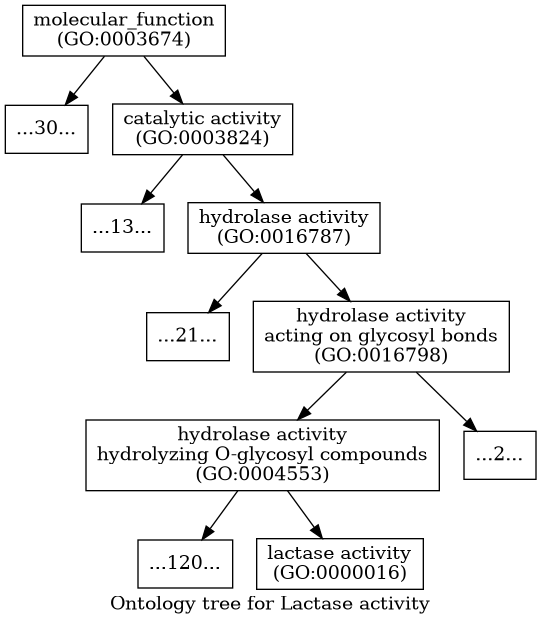

In [20]:
g.draw('graph.png')
Image("graph.png")
